<a href="https://colab.research.google.com/github/mipypf/practical-mi-guide/blob/develop/chapter4/src/text_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# テキスト分類のタスクを実行
### 使用するデータセットの参考文献
 - https://www.rondhuit.com/download.html#ldcc

## データセットのダウンロード
 - https://www.rondhuit.com/download.html#ldcc からldcc-20140209.tar.gzをダウンロード

## Google Colabの準備

In [1]:
# Google Colabを利用する場合はTrue、そうでない場合はFalseとする
colab = True

In [2]:
# Google Colabのファイルをクリックし、ldcc-20140209.tar.gzをドラッグ＆ドロップしてアップロード
# ldcc-20140209.tar.gzrを以下のコマンドで解凍する
!mv ldcc-20140209.tar.gz ldcc-20140209.tar
!tar xvf ldcc-20140209.tar > /dev/null

In [3]:
if colab:
  INPUT_FILE_PATH = "./"
  OUTPUT_FILE_PATH = "./"
else:
  INPUT_FILE_PATH = "../input/"
  OUTPUT_FILE_PATH = "../output/"

## ライブラリをインポート

In [4]:
! pip install scikit-learn==1.3.2 #ライブラリのverによっては次元圧縮の挙動が異なることがあるため注意
! pip install numpy==1.26.4
! pip install pandas==2.2.2
! pip install umap-learn==0.5.5
!pip install fugashi #"tohoku-nlp/bert-base-japanese-char"の駆動に必要
!pip install ipadic #"tohoku-nlp/bert-base-japanese-char"の駆動に必要
!pip install unidic_lite #"tohoku-nlp/bert-base-japanese-char"の駆動に必要

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 78.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.4 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86834 sha256=b773b8c3dfb1775de8672296f56cde61296d84734c59ee8777a8620e5bb9743f
  Stored in directory: /root/.cache/pip/wheels/de/07/2e/814a6ee82e37528f2044a609a431028375b149bc31f03c0e27
Successfully built umap-learn
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.0/698.0 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 93.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ipadic: filename=ipadic-1.0.0

In [5]:
import gc
import glob
import os

import pandas as pd
from tqdm.notebook import tqdm

tqdm.pandas()

import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import umap
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

## グラフ表示の際のフォント種類やフォントサイズを設定

In [6]:
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 20

## データを読み込み、データフレームに格納

In [7]:
# ファイルの読み込みの関数
def read_file(file_path):
    with open(file_path, "r") as f:
        text = f.read()
    return text


# 1フォルダの読み込みの関数
def read_folder(folder_path):
    files = glob.glob(folder_path + "/*.txt")
    texts = [read_file(file) for file in files]
    return texts


# 複数フォルダの読み込みの関数
def read_folders(folder_paths):
    texts = [read_folder(folder_path) for folder_path in folder_paths]
    return texts


# フォルダのパスを取得
folder_paths = glob.glob(INPUT_FILE_PATH + "text/*")

# フォルダごとにデータフレームを作成
dfs = []
for folder_path in tqdm(folder_paths):
    folder_name = os.path.basename(folder_path)
    texts = read_folder(folder_path)
    df = pd.DataFrame({"text": texts, "label": folder_name})
    dfs.append(df)

# 各データフレームを結合
df = pd.concat(dfs, ignore_index=True)

# labelごとのデータ数を確認
print(df["label"].value_counts())

  0%|          | 0/11 [00:00<?, ?it/s]

label
sports-watch      901
it-life-hack      871
dokujo-tsushin    871
smax              871
movie-enter       871
kaden-channel     865
peachy            843
topic-news        771
livedoor-homme    512
Name: count, dtype: int64


In [8]:
df

,text,label
0,http://news.livedoor.com/article/detail/561397...,sports-watch
1,http://news.livedoor.com/article/detail/527394...,sports-watch
2,http://news.livedoor.com/article/detail/580859...,sports-watch
3,http://news.livedoor.com/article/detail/632534...,sports-watch
4,http://news.livedoor.com/article/detail/465928...,sports-watch
...,...,...
7371,http://news.livedoor.com/article/detail/639739...,movie-enter
7372,http://news.livedoor.com/article/detail/620355...,movie-enter
7373,http://news.livedoor.com/article/detail/597613...,movie-enter
7374,http://news.livedoor.com/article/detail/678184...,movie-enter


In [9]:
df["text"][0]

'http://news.livedoor.com/article/detail/5613974/\n2011-06-07T08:00:00+0900\n【Sports Watch】坂本の夜遊びに原監督が激怒、美人記者と夜の街へ\n今月に入り、3位に浮上はしたものの、故障者も多く、いまひとつ波に乗り切れない原・巨人だが、本日7日発売の「週刊アサヒ芸能」（6.16号）では、本来ならチームの牽引役となるべき坂本勇人の不調にまつわる衝撃的な見出しが躍った。\n\n『巨人原監督が激怒した 坂本の「美人記者お持ち帰り」事件』と題した特集記事がそれだ。同誌にコメントする球団関係者は、坂本の不調について「古傷の腰痛もあるので、周囲はオフから坂本がちゃんと体調管理をしているか心配していた。ところが本人に自覚が見えないばかりか、シーズン前から夜遊びが激しくなったんです。『こんなことでシーズンを乗り切る体力や古傷をカバーする筋力が作れるのか？』と不安視する声が上がっていましたが、案の定、最近の坂本は疲労が抜けにくい体になっているといいます」と指摘をする。\n\nまた、震災直後の3月13日、巨人が甲子園で合同練習を行った際、坂本が欠場し、原監督からペナルティーを課されたことがあった。この時、原監督はマスコミに対し、「体調維持というものを怠った」と説明したが、その原因は坂本の前夜の行動にあったというのだ。\n\n練習前夜、マスコミとの親睦を深める飲み会に出席したという坂本について、スポーツ紙のデスクは「なんとその場で、プロ野球担当の美人女性記者と意気投合し、夜の街にお持ち帰りして消えたそうです。そのまま翌日は宿舎に朝帰りする門限破りだったといいます。翌日の試合後に坂本は欠場理由について、『それはちょっと・・・』と言葉を濁していた」と明かしている。\n\nこれなら原監督が怒るのも当然か。前出の球団関係者は、「遠征先はもちろん、都内でも六本木や西麻布で頻繁に目撃されている。しかも『紳士たれ』がモットーである巨人の選手とは思えない遊び方のようで、接客するホステスたちからの評判もよろしくないといいます。息抜きは当然必要ですが、試合に影響するほど遊んでいるようではいただけない」とも語っている。\n\n・週刊アサヒ芸能 ［ライト版］＜デジタル＞（PC版）\n'

## データの前処理

In [10]:
# df['text']の文章からhttps://～を削除する
df["text"] = df["text"].str.replace(
    "https?://[\w/:%#\$&\?\(\)~\.=\+\-]+", "", regex=True
)
df

,text,label
0,\n2011-06-07T08:00:00+0900\n【Sports Watch】坂本の夜...,sports-watch
1,\n2011-01-17T11:00:00+0900\n【Sports Watch】武田氏キ...,sports-watch
2,\n2011-08-25T08:30:00+0900\n【Sports Watch】“五輪の...,sports-watch
3,\n2012-03-01T08:30:00+0900\n日本代表ホームで完敗、北澤豪氏は「か...,sports-watch
4,\n2010-03-15T07:00:00+0900\n【Sports Watch】俊輔“い...,sports-watch
...,...,...
7371,\n2012-03-26T10:30:00+0900\n“最凶”の教育映画『先生を流産させる...,movie-enter
7372,\n2012-01-20T10:00:00+0900\nディズニーの夢を叶えた巨編『ジョン・...,movie-enter
7373,\n2011-10-28T23:37:00+0900\n今からでも間に合う！知ったふりして映...,movie-enter
7374,\n2012-07-23T11:00:00+0900\n【いちおう妖ヶ劇場】最終話：A級映画...,movie-enter


In [11]:
# df['text']の文章から改行コードを削除する
df["text"] = df["text"].str.replace("\n", "", regex=True)
df

,text,label
0,2011-06-07T08:00:00+0900【Sports Watch】坂本の夜遊びに原...,sports-watch
1,2011-01-17T11:00:00+0900【Sports Watch】武田氏キッパリ ...,sports-watch
2,2011-08-25T08:30:00+0900【Sports Watch】“五輪の時もずっ...,sports-watch
3,2012-03-01T08:30:00+0900日本代表ホームで完敗、北澤豪氏は「かなり危険...,sports-watch
4,2010-03-15T07:00:00+0900【Sports Watch】俊輔“いいプレー...,sports-watch
...,...,...
7371,2012-03-26T10:30:00+0900“最凶”の教育映画『先生を流産させる会』の劇...,movie-enter
7372,2012-01-20T10:00:00+0900ディズニーの夢を叶えた巨編『ジョン・カーター...,movie-enter
7373,2011-10-28T23:37:00+0900今からでも間に合う！知ったふりして映画祭デー...,movie-enter
7374,2012-07-23T11:00:00+0900【いちおう妖ヶ劇場】最終話：A級映画に永久に...,movie-enter


## Transformer系列のモデルを用いたベクトル化を行う

In [12]:
# モデルの読み込み
model = SentenceTransformer("hotchpotch/static-embedding-japanese", device="cpu") #CPUで実行

# ベクトル化
vectors = model.encode(df["text"].values, show_progress_bar=True)

modules.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/205 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/28.9k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/134M [00:00<?, ?B/s]

0_StaticEmbedding/tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

Batches:   0%|          | 0/231 [00:00<?, ?it/s]

In [13]:
# vectorsをデータフレームに変換
vectors_df = pd.DataFrame(vectors)
vectors_df

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.295252,0.083818,-1.287807,-0.254068,-0.084021,-0.015967,0.078480,-0.338088,-0.406443,0.202779,...,0.138170,0.087737,-0.036691,-0.414351,-0.187899,0.096961,0.138292,-0.530466,0.266782,0.565787
1,-0.513471,1.038250,-0.475892,0.435969,0.101331,-0.103637,0.143361,-0.257490,-0.318826,0.574923,...,0.058024,-0.290764,0.171464,0.000539,-0.276535,-0.060401,-0.094755,-0.388227,0.439140,-0.233137
2,-0.658875,0.141486,-0.682572,-0.540505,-0.045049,0.040653,-0.024217,-0.551157,0.344496,0.692780,...,-0.147921,-0.292486,-0.146978,-0.497440,-0.343668,0.183274,-0.152876,-0.311741,0.400661,-0.193854
3,0.084124,0.840482,-0.386164,-0.052409,0.124557,-0.097093,-0.217961,0.064213,0.046569,0.743921,...,-0.435140,-0.245311,-0.075696,-0.280643,0.088732,0.307748,-0.473481,-0.340706,0.207473,0.180733
4,-0.961485,1.070085,-0.990971,0.556624,0.248430,-0.027747,-0.275013,-0.583789,-0.059276,0.938438,...,-0.155583,-0.084261,-0.195247,-0.203702,-0.407993,0.560856,-0.044278,-0.124076,0.414622,0.194419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7371,0.011440,-0.274819,-0.415403,0.040474,-0.739746,-0.180488,0.118595,-0.164633,-0.085684,-0.274122,...,-0.173808,-0.137192,-0.120364,0.022267,0.005810,-0.167390,-0.079346,-0.303481,0.194964,0.113530
7372,-0.484408,0.587691,-0.053683,0.017771,-0.311818,-0.127078,0.477053,0.167218,0.048625,-0.069416,...,0.120276,0.325863,-0.259370,-0.179803,0.050340,0.138368,-0.261251,0.302372,0.043525,0.063070
7373,0.830980,0.282221,-0.488085,0.270826,-0.448004,-0.648686,0.104942,0.089233,0.090980,-0.078415,...,-0.219135,0.114404,-0.413732,-0.437182,0.303570,-0.631192,-0.142495,-0.221668,0.282434,0.655421
7374,0.409863,0.919838,0.003443,-0.124227,-1.164865,-0.607643,0.058679,0.303151,-0.268977,-0.345915,...,-0.028619,0.248240,-0.563722,0.053630,0.346862,-0.528628,0.211432,-0.216186,0.182798,0.162670


## ベクトル化したテキストデータをUMAPを用いて2次元空間に可視化する

In [14]:
# dfとvectors_dfを結合
df = pd.concat([df, vectors_df], axis=1)
df

,text,label,0,1,2,3,4,5,6,7,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,2011-06-07T08:00:00+0900【Sports Watch】坂本の夜遊びに原...,sports-watch,0.295252,0.083818,-1.287807,-0.254068,-0.084021,-0.015967,0.078480,-0.338088,...,0.138170,0.087737,-0.036691,-0.414351,-0.187899,0.096961,0.138292,-0.530466,0.266782,0.565787
1,2011-01-17T11:00:00+0900【Sports Watch】武田氏キッパリ ...,sports-watch,-0.513471,1.038250,-0.475892,0.435969,0.101331,-0.103637,0.143361,-0.257490,...,0.058024,-0.290764,0.171464,0.000539,-0.276535,-0.060401,-0.094755,-0.388227,0.439140,-0.233137
2,2011-08-25T08:30:00+0900【Sports Watch】“五輪の時もずっ...,sports-watch,-0.658875,0.141486,-0.682572,-0.540505,-0.045049,0.040653,-0.024217,-0.551157,...,-0.147921,-0.292486,-0.146978,-0.497440,-0.343668,0.183274,-0.152876,-0.311741,0.400661,-0.193854
3,2012-03-01T08:30:00+0900日本代表ホームで完敗、北澤豪氏は「かなり危険...,sports-watch,0.084124,0.840482,-0.386164,-0.052409,0.124557,-0.097093,-0.217961,0.064213,...,-0.435140,-0.245311,-0.075696,-0.280643,0.088732,0.307748,-0.473481,-0.340706,0.207473,0.180733
4,2010-03-15T07:00:00+0900【Sports Watch】俊輔“いいプレー...,sports-watch,-0.961485,1.070085,-0.990971,0.556624,0.248430,-0.027747,-0.275013,-0.583789,...,-0.155583,-0.084261,-0.195247,-0.203702,-0.407993,0.560856,-0.044278,-0.124076,0.414622,0.194419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7371,2012-03-26T10:30:00+0900“最凶”の教育映画『先生を流産させる会』の劇...,movie-enter,0.011440,-0.274819,-0.415403,0.040474,-0.739746,-0.180488,0.118595,-0.164633,...,-0.173808,-0.137192,-0.120364,0.022267,0.005810,-0.167390,-0.079346,-0.303481,0.194964,0.113530
7372,2012-01-20T10:00:00+0900ディズニーの夢を叶えた巨編『ジョン・カーター...,movie-enter,-0.484408,0.587691,-0.053683,0.017771,-0.311818,-0.127078,0.477053,0.167218,...,0.120276,0.325863,-0.259370,-0.179803,0.050340,0.138368,-0.261251,0.302372,0.043525,0.063070
7373,2011-10-28T23:37:00+0900今からでも間に合う！知ったふりして映画祭デー...,movie-enter,0.830980,0.282221,-0.488085,0.270826,-0.448004,-0.648686,0.104942,0.089233,...,-0.219135,0.114404,-0.413732,-0.437182,0.303570,-0.631192,-0.142495,-0.221668,0.282434,0.655421
7374,2012-07-23T11:00:00+0900【いちおう妖ヶ劇場】最終話：A級映画に永久に...,movie-enter,0.409863,0.919838,0.003443,-0.124227,-1.164865,-0.607643,0.058679,0.303151,...,-0.028619,0.248240,-0.563722,0.053630,0.346862,-0.528628,0.211432,-0.216186,0.182798,0.162670


In [15]:
# dfのvector列をUMAPを使って次元削減

# UMAP
umap_model = umap.UMAP(n_components=2, random_state=42) # n_neighborsのデフォルト値は15
umap_result = umap_model.fit_transform(vectors)

# UMAPの結果をデータフレームに変換
umap_df = pd.DataFrame(umap_result, columns=["umap1", "umap2"])

# dfとumap_dfを結合
df = pd.concat([df, umap_df], axis=1)
df

,text,label,0,1,2,3,4,5,6,7,...,1016,1017,1018,1019,1020,1021,1022,1023,umap1,umap2
0,2011-06-07T08:00:00+0900【Sports Watch】坂本の夜遊びに原...,sports-watch,0.295252,0.083818,-1.287807,-0.254068,-0.084021,-0.015967,0.078480,-0.338088,...,-0.036691,-0.414351,-0.187899,0.096961,0.138292,-0.530466,0.266782,0.565787,8.525887,-3.523928
1,2011-01-17T11:00:00+0900【Sports Watch】武田氏キッパリ ...,sports-watch,-0.513471,1.038250,-0.475892,0.435969,0.101331,-0.103637,0.143361,-0.257490,...,0.171464,0.000539,-0.276535,-0.060401,-0.094755,-0.388227,0.439140,-0.233137,8.243706,-4.481728
2,2011-08-25T08:30:00+0900【Sports Watch】“五輪の時もずっ...,sports-watch,-0.658875,0.141486,-0.682572,-0.540505,-0.045049,0.040653,-0.024217,-0.551157,...,-0.146978,-0.497440,-0.343668,0.183274,-0.152876,-0.311741,0.400661,-0.193854,7.296819,-3.962556
3,2012-03-01T08:30:00+0900日本代表ホームで完敗、北澤豪氏は「かなり危険...,sports-watch,0.084124,0.840482,-0.386164,-0.052409,0.124557,-0.097093,-0.217961,0.064213,...,-0.075696,-0.280643,0.088732,0.307748,-0.473481,-0.340706,0.207473,0.180733,8.444901,-4.764650
4,2010-03-15T07:00:00+0900【Sports Watch】俊輔“いいプレー...,sports-watch,-0.961485,1.070085,-0.990971,0.556624,0.248430,-0.027747,-0.275013,-0.583789,...,-0.195247,-0.203702,-0.407993,0.560856,-0.044278,-0.124076,0.414622,0.194419,8.093620,-4.502765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7371,2012-03-26T10:30:00+0900“最凶”の教育映画『先生を流産させる会』の劇...,movie-enter,0.011440,-0.274819,-0.415403,0.040474,-0.739746,-0.180488,0.118595,-0.164633,...,-0.120364,0.022267,0.005810,-0.167390,-0.079346,-0.303481,0.194964,0.113530,7.833770,-1.044808
7372,2012-01-20T10:00:00+0900ディズニーの夢を叶えた巨編『ジョン・カーター...,movie-enter,-0.484408,0.587691,-0.053683,0.017771,-0.311818,-0.127078,0.477053,0.167218,...,-0.259370,-0.179803,0.050340,0.138368,-0.261251,0.302372,0.043525,0.063070,7.563191,0.975599
7373,2011-10-28T23:37:00+0900今からでも間に合う！知ったふりして映画祭デー...,movie-enter,0.830980,0.282221,-0.488085,0.270826,-0.448004,-0.648686,0.104942,0.089233,...,-0.413732,-0.437182,0.303570,-0.631192,-0.142495,-0.221668,0.282434,0.655421,8.488389,0.667850
7374,2012-07-23T11:00:00+0900【いちおう妖ヶ劇場】最終話：A級映画に永久に...,movie-enter,0.409863,0.919838,0.003443,-0.124227,-1.164865,-0.607643,0.058679,0.303151,...,-0.563722,0.053630,0.346862,-0.528628,0.211432,-0.216186,0.182798,0.162670,8.811907,-0.021243


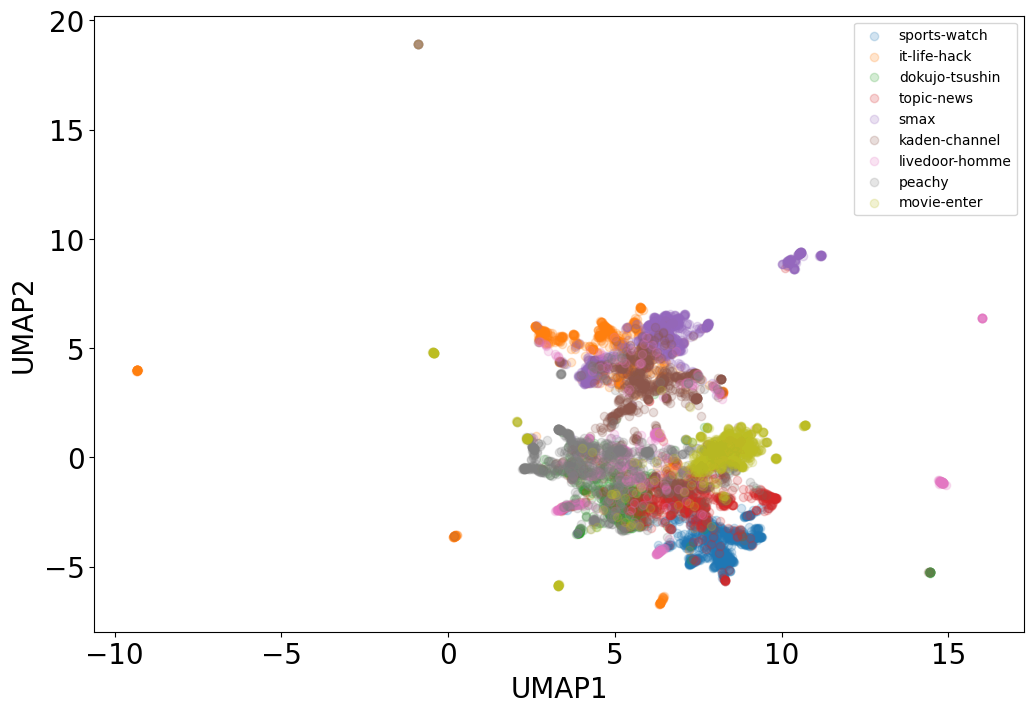

In [22]:
# umap1とumap2をプロット、labelごとに色分けして透過度を変える
plt.figure(figsize=(12, 8))
for label in df["label"].unique():
    plt.scatter(
        df[df["label"] == label]["umap1"],
        df[df["label"] == label]["umap2"],
        label=label,
        alpha=0.2,
    )
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(fontsize=10)
plt.show()

## 実行環境のライブラリverを保存

In [17]:
!pip freeze > requirements_text_clustering.txt

In [18]:
from google.colab import files

files.download('requirements_text_clustering.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>